<a href="https://colab.research.google.com/github/JonathanLehner/Colab-collection/blob/master/MRCNN_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN Demo - Counting

This is a [Mask R-CNN](https://arxiv.org/abs/1703.06870) colab notebook using the open source project [matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

Follow this to make your picam stream:
https://docs.dataplicity.com/docs/stream-live-video-from-your-pi

Our pi is at 
https://coverless-gnu-0291.dataplicity.io/?action=stream

In [0]:
# define variables
import os
repository_url = 'https://github.com/JonathanLehner/Colab-collection'
repository_name = os.path.basename(repository_url)
loader_path = './products.py'

products_model = 'https://github.com/JonathanLehner/Colab-collection/releases/download/0.1/mask_rcnn_products_0090_new.h5'
products_model_name = os.path.basename(products_model)
products_data_url = 'https://github.com/JonathanLehner/Colab-collection/releases/download/0.1/labeled_training_images3.0.zip'
products_filename = os.path.basename(products_data_url)
products_filename_wo_ext = 'labeled_training_images'

server_address = 'www.grabigo.com'
pi_address = 'https://coverless-gnu-0291.dataplicity.io/?action=stream'
test_category = "/test_do_not_label"

# Products class names
# Index of the class in the list is its ID. For example, to get ID of
# the huerlimann class, use: class_names.index('huerlimann')
class_names = ['BG', "apple", "banana", "feldschloesschen", "huerlimann", "ramen", "redbull", "tuc", "tuna", "x", "y", "z"]

mode = "counting"

SHELF_ID = "BKc4cY4DBw65XcTpc"

In [0]:
import os
from os.path import exists, join, basename

project_name = "Mask_RCNN"
if not exists(project_name):
  # clone and install
  !git clone -q https://github.com/matterport/Mask_RCNN.git
  !cd $project_name && pip install -q -r requirements.txt
  
import sys
sys.path.append(project_name)

In [0]:
# download model files
%cd /content/Mask_RCNN/
os.system('rm {0}'.format(products_model_name))
os.system('wget {0}'.format(products_model))
%cd /content/

In [0]:
# download training dataset
os.system('wget {0}'.format(products_data_url))
print('unzip {0}'.format(products_filename))
os.system('unzip {0}'.format(products_filename))

!rm -rf /content/Mask_RCNN/datasets
!mkdir /content/Mask_RCNN/datasets

print('mv /content/{0} /content/Mask_RCNN/datasets/{1}'.format(products_filename_wo_ext,products_filename_wo_ext))
os.system('mv /content/{0} /content/Mask_RCNN/datasets/{1}'.format(products_filename_wo_ext,products_filename_wo_ext))

In [0]:
%cd /content/Mask_RCNN
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Products trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
PRODUCTS_WEIGHTS_PATH = "/content/Mask_RCNN/{0}".format(products_model_name)  # TODO: update this path

## Configurations

In [0]:
# load the training script
%cd /content/Mask_RCNN/samples/
os.system('rm -r {0}'.format(repository_name))

print('git clone {0}'.format(repository_url))
os.system('git clone {0}'.format(repository_url))

In [0]:
%cd /content/Mask_RCNN/samples/Colab-collection
products = __import__("products")
%cd /content/Mask_RCNN/

config = products.ProductConfig()
PRODUCTS_DIR = os.path.join(ROOT_DIR, "datasets/{0}".format(products_filename_wo_ext))

In [0]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

## Notebook Preferences

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



## Load Validation Dataset

In [0]:
# Load validation dataset
dataset = products.ProductDataset()

print(products)
dataset.load_products(PRODUCTS_DIR+test_category, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

## Load Model

In [0]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [0]:
# Set path to products weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = '/content/Mask_RCNN/{0}'.format(products_model_name)

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

## Set up the connection to Meteor server

In [0]:
# Connect to the server
!pip install python-meteor
from MeteorClient import MeteorClient
client = MeteorClient('wss://{0}/websocket'.format(server_address))
client.connect()
print('connected')

In [0]:
# define callback functions
def changed(collection, id, fields, cleared):
    print('* CHANGED {} {}'.format(collection, id))
    if(collection == "users"):
        for key, value in fields.items():
            if(key == "profile"):
                profile = value
                #print(profile)
                basket_content = profile['basket_content']
                print(basket_content)
                for item in basket_content:
                    item_label = item['name']
                    item_qty = item['quantity']
                    products[item_label] = item_qty
    for key, value in fields.items():
        print('  - FIELD {} {}'.format(key, value))
    for key, value in cleared.items():
        print('  - CLEARED {} {}'.format(key, value))
        
client.on('changed', changed)

def callback_function(error, result):
    print('callback')
    print(result)
    if error:
        print(error)
        return

    print(result)

## Run Detections on stream from Raspberry Pi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


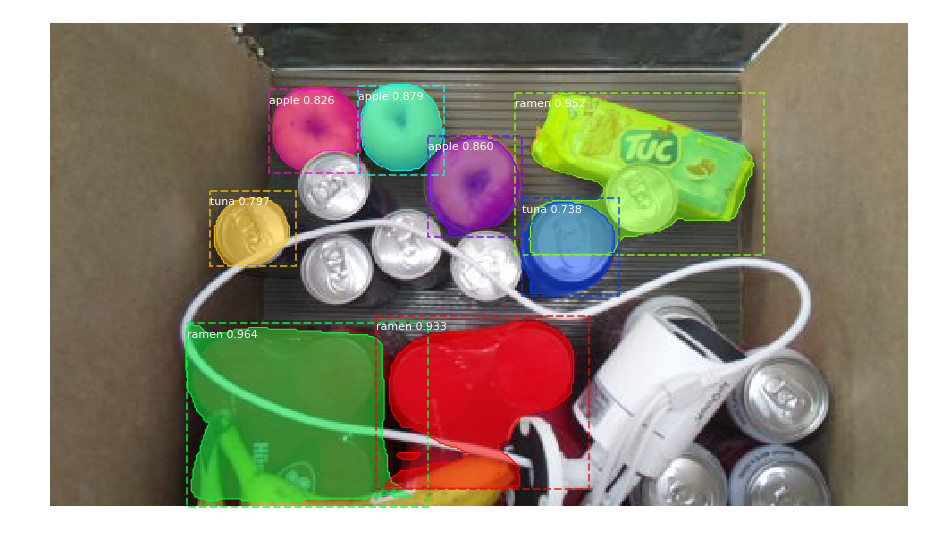

Object: ramen, Quantity: 3
 -- Quantity changed by 3
Object: apple, Quantity: 3
 -- Quantity changed by 3
Object: tuna, Quantity: 2
 -- Quantity changed by 2
1
2
3
4
5
6
7
8
9
10
11
12
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


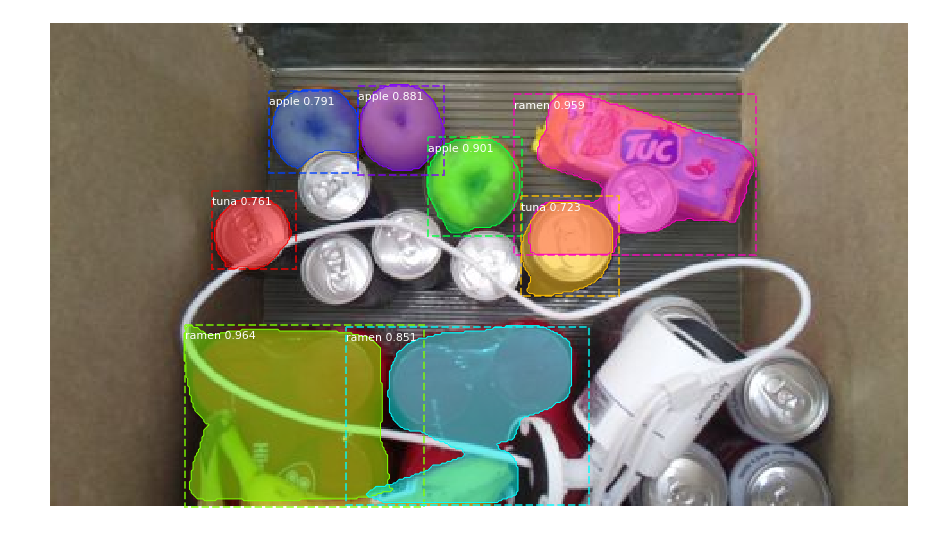

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 2
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


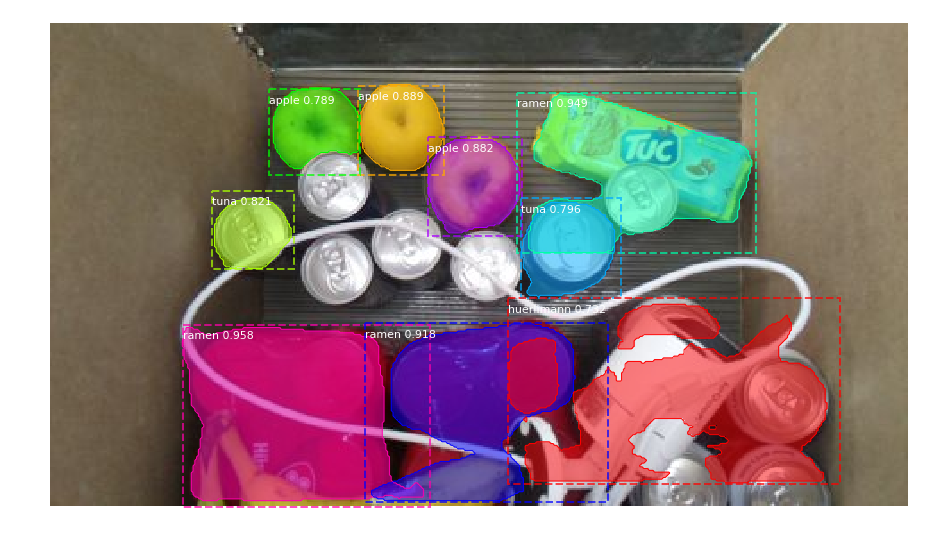

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 2
Object: huerlimann, Quantity: 1
 -- Quantity changed by 1
61
62
63
64
65
66
67
68
69
70
71
72
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


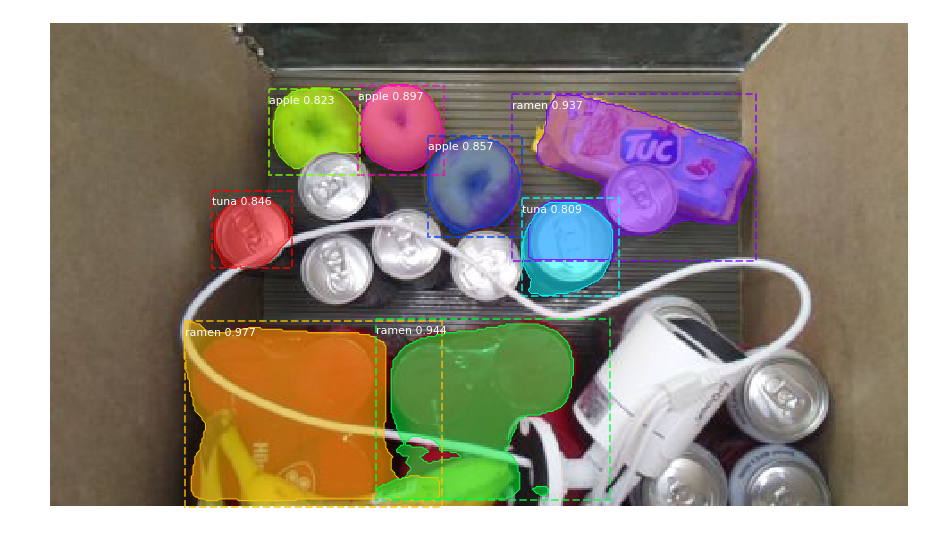

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 2
 -- Object: huerlimann, Quantity: 1 was removed
91
92
93
94
95
96
97
98
99
100
101
102
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


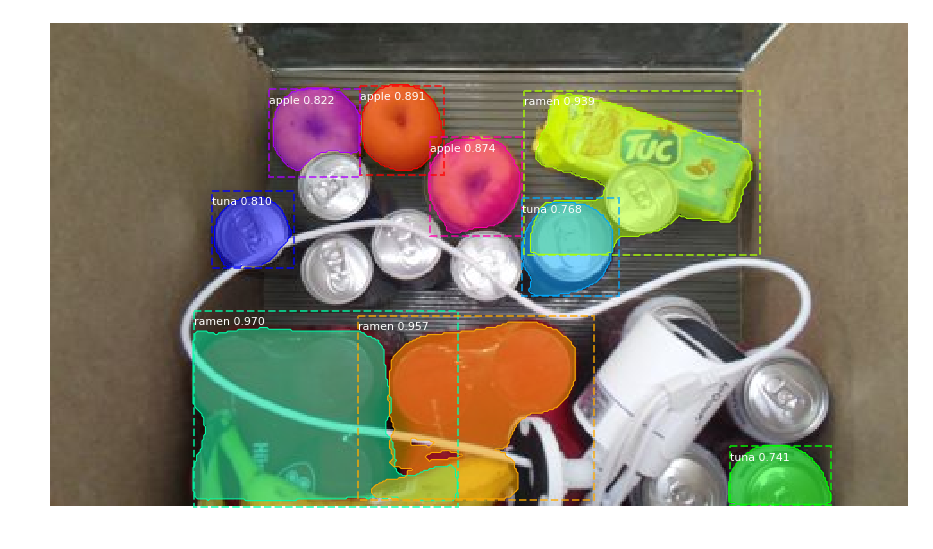

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 3
 -- Quantity changed by 1
121
122
123
124
125
126
127
128
129
130
131
132
133
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


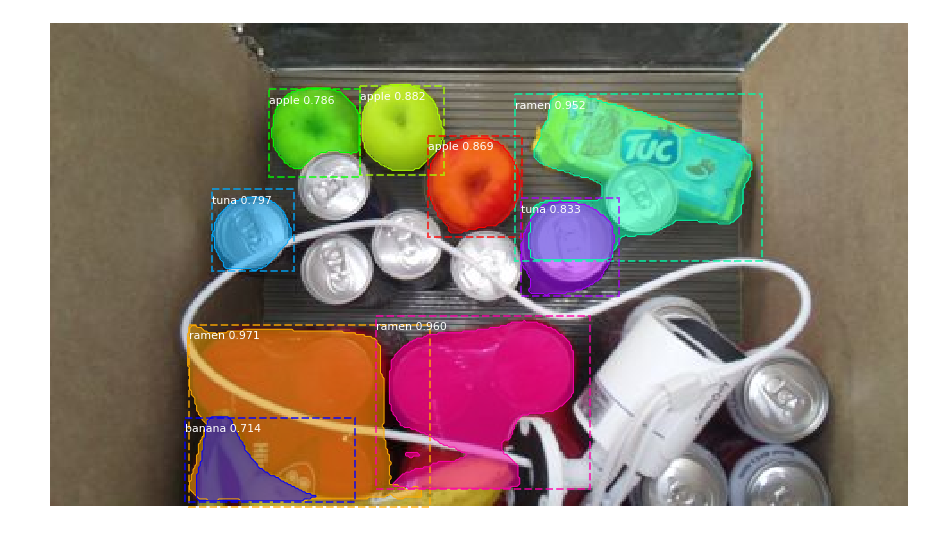

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 2
 -- Quantity changed by -1
Object: banana, Quantity: 1
 -- Quantity changed by 1
151
152
153
154
155
156
157
158
159
160
161
162
163
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


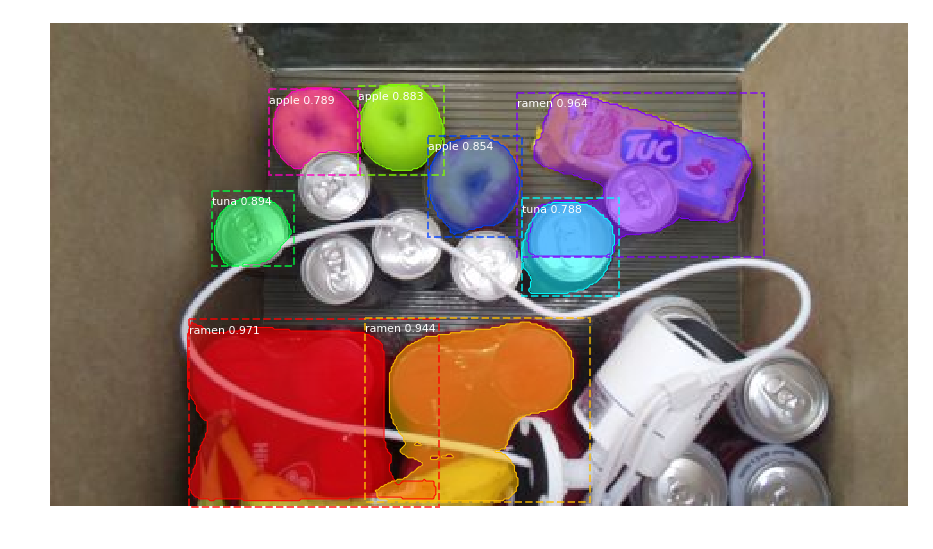

Object: ramen, Quantity: 3
Object: tuna, Quantity: 2
Object: apple, Quantity: 3
 -- Object: banana, Quantity: 1 was removed
181
182
183
184
185
186
187
188
189
190
191
192
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


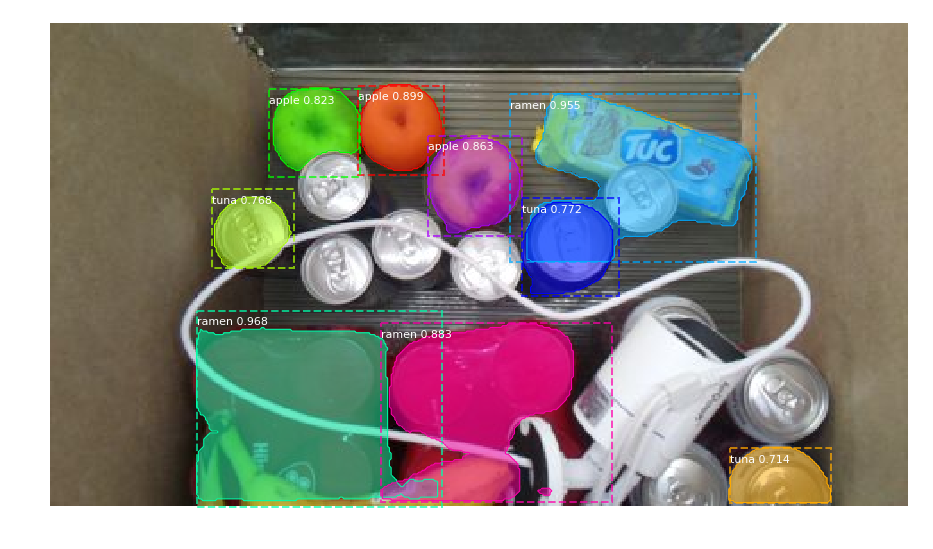

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 3
 -- Quantity changed by 1
211
212
213
214
215
216
217
218
219
220
221
222
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


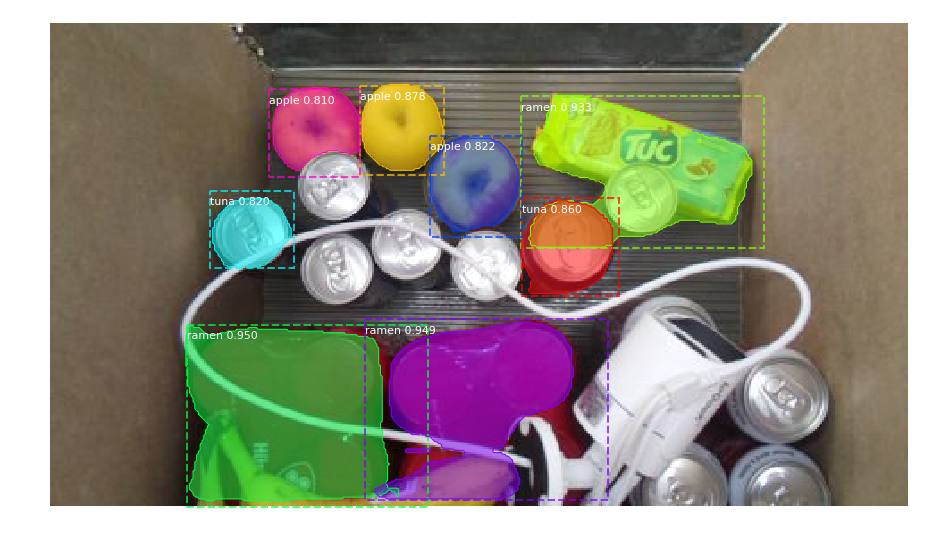

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 2
 -- Quantity changed by -1
241
242
243
244
245
246
247
248
249
250
251
252
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


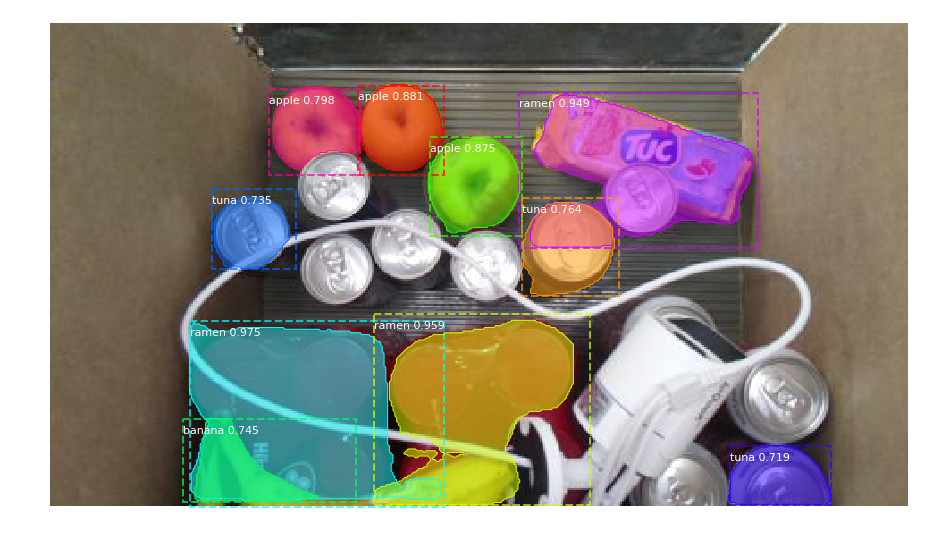

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 3
 -- Quantity changed by 1
Object: banana, Quantity: 1
 -- Quantity changed by 1
271
272
273
274
275
276
277
278
279
280
281
282
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


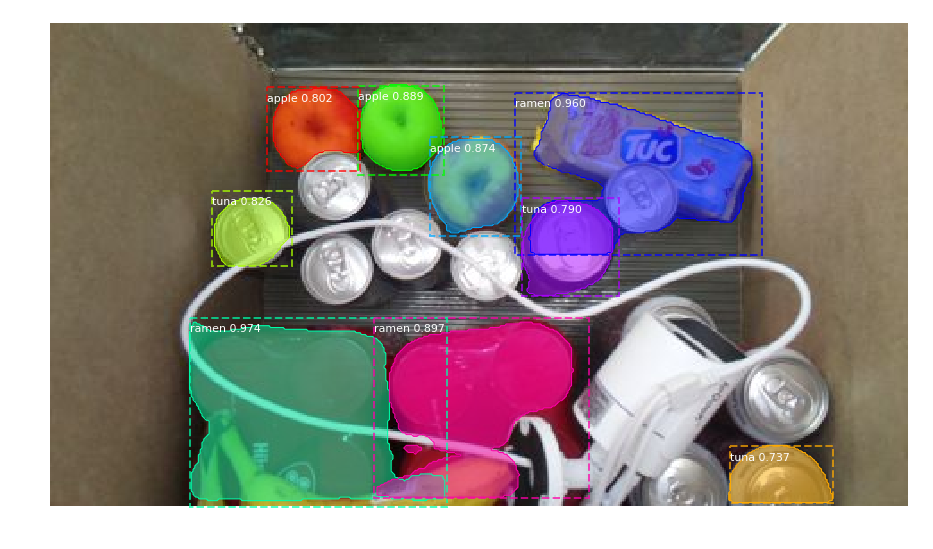

Object: ramen, Quantity: 3
Object: apple, Quantity: 3
Object: tuna, Quantity: 3
 -- Object: banana, Quantity: 1 was removed
301
302
303
304
305
306
307
308
309
callback
None
{'isClientSafe': True, 'error': 404, 'reason': "Method 'modifyBasket' not found", 'message': "Method 'modifyBasket' not found [404]", 'errorType': 'Meteor.Error'}


KeyboardInterrupt: ignored

In [83]:
import time
import cv2
import urllib.request as ur

import numpy as np
from google.colab.patches import cv2_imshow
#from IPython.display import clear_output

# run sudo ifconfig inside the pi to get the local network address "inet" but then need local hw 
# http://10.4.14.67/?action=stream
# https://stackoverflow.com/questions/54949143/opencv-unable-to-read-video-from-mjpeg-stream
stream=ur.urlopen(pi_address)
bytestring=b''
counter = 0
counter_list_prev = dict()
while True:
    bytestring+=stream.read(1024)
    a = bytestring.find(b'\xff\xd8')
    b = bytestring.find(b'\xff\xd9')
    if a !=- 1 and b != -1:
        jpg = bytestring[a:b+2]
        bytestring= bytestring[b+2:]
        i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8),cv2.IMREAD_COLOR)
        
        if(mode == "training" and counter % 10 == 0): # every second
            #save image to file
            img_label = training_label + str(counter) + ".jpg"
            cv2.imwrite(os.path.join('training_images/'+training_label, img_label), i)
            cv2_imshow(i)

        if(mode == "counting" and counter % 30 == 0): # with 10FPS this is one per three seconds
            #from matplotlib import pyplot as plt
            #plt.subplot(211),plt.imshow(i)
            #plt.xticks([]),plt.yticks([])
            #plt.pause(0.2);
            #cv2_imshow(i)
          
            image = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
            # Run detection
            results = model.detect([image], verbose=0)
            #results = model.detect([image], verbose=1)
            #print(results)

            # Visualize results
            r = results[0]
            visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                class_names, r['scores'])

            import collections
            class_ids = r['class_ids']
            counter_list = collections.Counter(class_ids)
             
            for key in counter_list:
                if not key in counter_list_prev:
                    counter_list_prev[key] = 0

                print("Object: {}, Quantity: {}".format(class_names[key], counter_list[key]))
                if counter_list_prev[key] != counter_list[key]:
                    difference = counter_list[key] - counter_list_prev[key]
                    print(" -- Quantity changed by {}".format(difference))
                    client.call('modifyBasket', [SHELF_ID, int(key), difference], callback_function)

            for key in counter_list_prev:  
                if key in counter_list_prev and key not in counter_list:
                  print(" -- Object: {}, Quantity: {} was removed".format(class_names[key], counter_list_prev[key]))
                  client.call('modifyBasket', [SHELF_ID, int(key), -counter_list_prev[key]], callback_function)

            #save detection result for comparison
            counter_list_prev = counter_list

        counter += 1
        print(counter)
        
    #not meaningful inside Google colab
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

    #time.sleep(0.1)